In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import json

pd.set_option('display.max_colwidth',200)

In [113]:
df = pd.read_csv('dataset.csv')

In [114]:
df.describe()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
count,23357,23286,23357,23357,23357,23357,15847,15847
unique,3540,49,23,2309,20452,3,22,290
top,627f50253b42607513a1c93bb68201ad,CA,Order,"{""Premium Membership"":""True""}",2022-03-16 08:20:51,ios,Apple,"iPhone12,1"
freq,498,8627,6116,5451,17,9586,9586,1489


In [115]:
df.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


## Process data

In [9]:
df.dtypes

userid                object
user_state            object
event_name            object
event_attributes      object
event_created_date    object
event_platform        object
device_manufacture    object
device_model          object
dtype: object

In [10]:
# transform string date to datetime object
df['event_created_date']= pd.to_datetime(df['event_created_date'])

In [11]:
# make 2D index
df_index = df.set_index([df['userid'], df['event_created_date']])

# extract userid unique values
unique_userids = df_index.index.get_level_values(0).unique()

# filter out events between subscription and cancelation
filtered_df = []
for index in unique_userids:
    sliced_df = df_index.loc[index]
    subscription = sliced_df[sliced_df['event_name'] == 'Subscription Premium']
    cancelation = sliced_df[sliced_df['event_name'] == 'Subscription Premium Cancel']
    if subscription.empty or cancelation.empty:
        df_index = df_index.drop([index])
        continue
    filtered_df.append(sliced_df[(sliced_df['event_created_date'] > subscription.iloc[0]['event_created_date']) & (sliced_df['event_created_date'] < cancelation.iloc[0]['event_created_date'])])

# collect filtered data in DataFrame object
filtered_df = pd.concat(filtered_df)
filtered_df = filtered_df.set_index([filtered_df['userid'], filtered_df['event_created_date']])
filtered_df = filtered_df.drop(columns=['userid', 'event_created_date'])

In [179]:
filtered_df

user_state  \
userid                           event_created_date               
a22abda7a39d747ab674cd13224b375a 2022-01-15 23:28:37         FL   
                                 2022-01-16 02:39:15         FL   
                                 2022-01-16 02:39:28         FL   
                                 2022-01-16 02:39:48         FL   
                                 2022-01-16 02:40:39         FL   
...                                                         ...   
6cd4b3af304d32aefeb446632209c00d 2022-04-15 18:01:33         DC   
                                 2022-04-15 18:02:36         DC   
                                 2022-04-15 19:29:11         DC   
387c88f25e204376acf003420663fef5 2022-04-16 18:53:16         AR   
                                 2022-04-16 18:56:00         AR   

                                                                               event_name  \
userid                           event_created_date                                         
a22abda7a39d747ab674cd13224b375a 2022-01-15 23:28:37  Account History Transaction Details   
                                 2022-01-16 02:39:15  Account History Transaction Details   
                                 2022-01-16 02:39:28  Account History Transaction Details   
                                 2022-01-16 02:39:48  Account History Transaction Details   
                                 2022-01-16 02:40:39                        Wallet Opened   
...                                                                                   ...   
6cd4b3af304d32aefeb446632209c00d 2022-04-15 18:01:33           Account Setup Profile Skip   
                                 2022-04-15 18:02:36                        Wallet Opened   
                                 2022-04-15 19:29:11            Chat Conversation Started   
387c88f25e204376acf003420663fef5 2022-04-16 18:53:16  Account History Transaction Details   
                                 2022-04-16 18:56:00                        Wallet Opened   

                                                                                                                            event_attributes  \
userid                           event_created_date                                                                                            
a22abda7a39d747ab674cd13224b375a 2022-01-15 23:28:37  {"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}   
                                 2022-01-16 02:39:15  {"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}   
                                 2022-01-16 02:39:28  {"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}   
                                 2022-01-16 02:39:48     {"Navigated From":"Account History","Status":"Paid","Type":"Pro Plan Subscription"}   
                                 2022-01-16 02:40:39                                                                                      {}   
...                                                                                                                                      ...   
6cd4b3af304d32aefeb446632209c00d 2022-04-15 18:01:33                                                               {"Screen":"Phone Number"}   
                                 2022-04-15 18:02:36                                                                                      {}   
                                 2022-04-15 19:29:11                                                                                      {}   
387c88f25e204376acf003420663fef5 2022-04-16 18:53:16           {"Navigated From":"Account History","Status":"Pending","Type":"Auto Payment"}   
                                 2022-04-16 18:56:00                                                                                      {}   

                                                     event_platform  \
userid                     

## Analyse high order columns

### Event names

<AxesSubplot: >

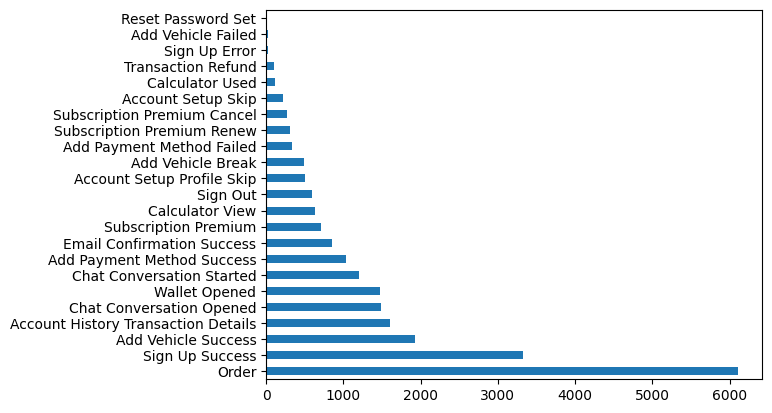

In [13]:
# plot with all event names
df['event_name'].value_counts().plot(kind='barh')

<AxesSubplot: >

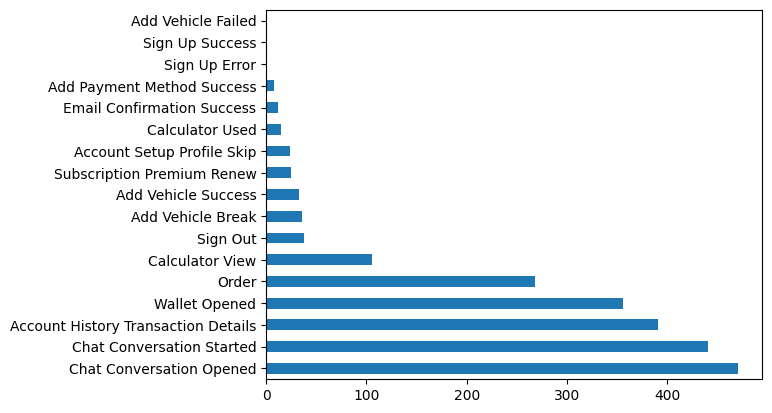

In [14]:
# plot with event names, which occur between subscription and cancelation
filtered_df['event_name'].value_counts().plot(kind='barh')

<AxesSubplot: >

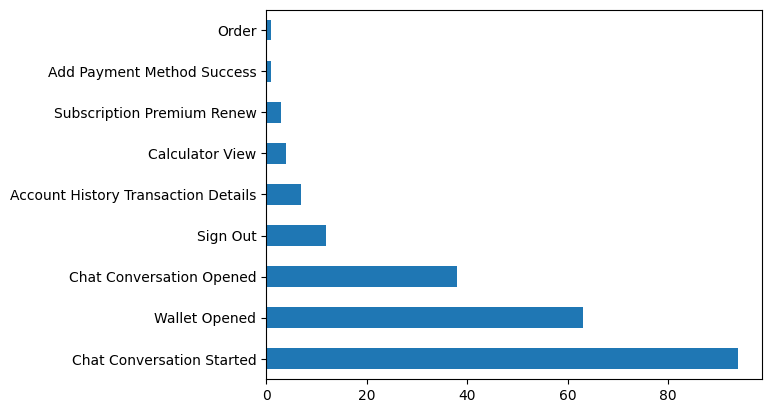

In [15]:
# plot with event names, which are last before cancelation
filtered_df.groupby(level=0).last()['event_name'].value_counts().plot(kind='barh')

<AxesSubplot: >

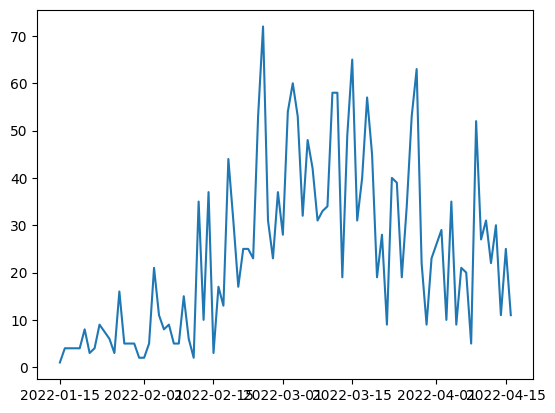

In [59]:
filtered_df.groupby(filtered_df.index.get_level_values(1).date)['event_name'].count().plot()

#### Short summary:

The most common event that occur before subscription cancellation is Chat conversation Opened and Chat Conversation Started. It is obvious as this action says that something went wrong. Generally, 1/3 of users calcel subscription after asking technical support.

Also, we already can shrink the number of event types to investigate to only 1/3 of all.

### Device properties

<AxesSubplot: >

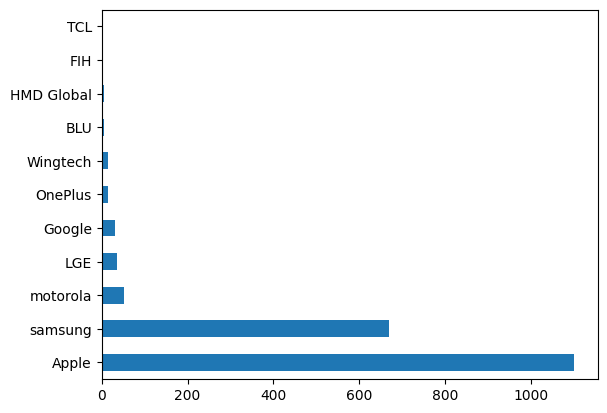

In [16]:
filtered_df['device_manufacture'].value_counts().plot(kind='barh')

<AxesSubplot: >

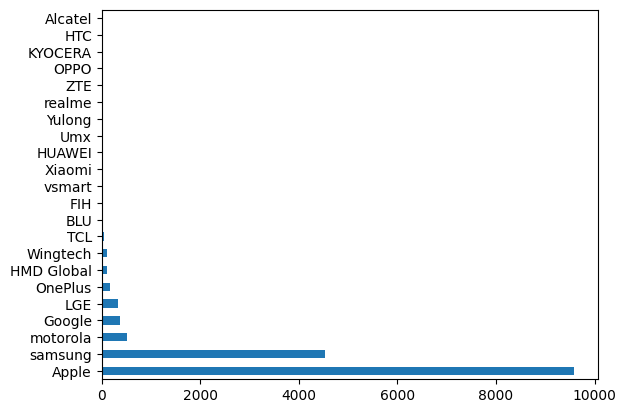

In [18]:
df['device_manufacture'].value_counts().plot(kind='barh')

<AxesSubplot: >

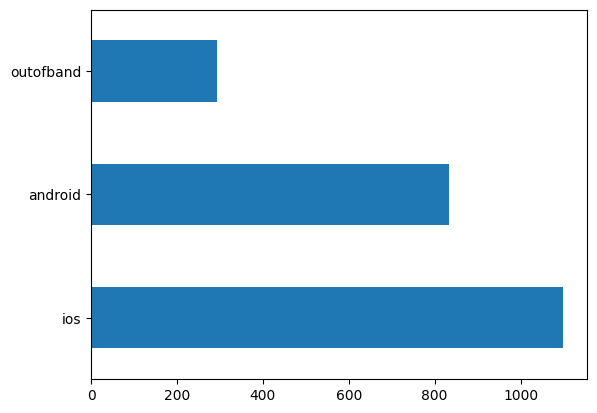

In [23]:
filtered_df['event_platform'].value_counts().plot(kind='barh')

<AxesSubplot: >

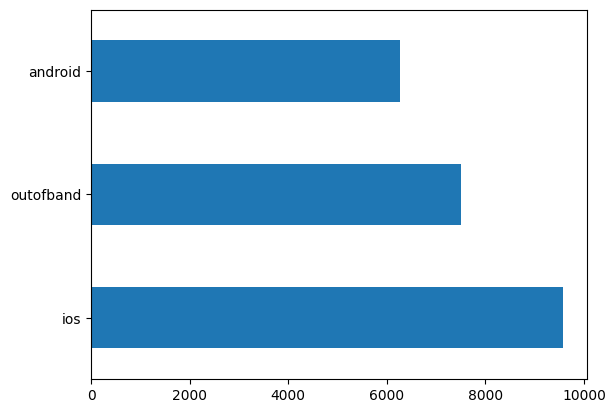

In [22]:
df['event_platform'].value_counts().plot(kind='barh')

<AxesSubplot: >

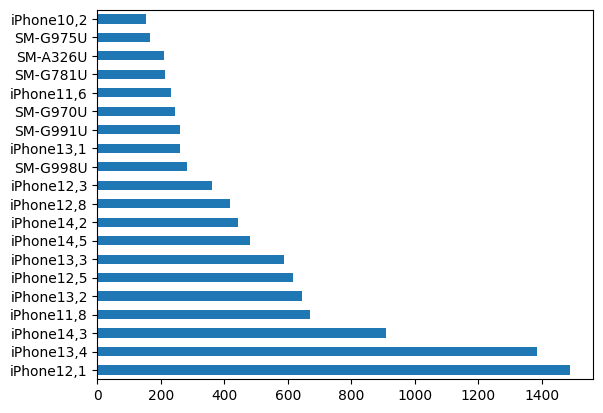

In [38]:
df['device_model'].value_counts().nlargest(20).plot(kind='barh')

<AxesSubplot: >

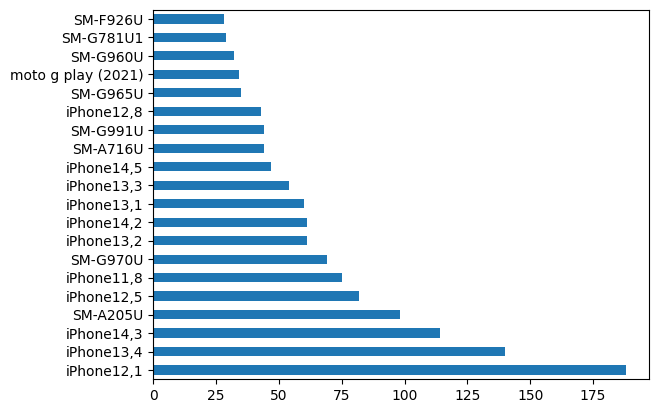

In [37]:
filtered_df['device_model'].value_counts().nlargest(20).plot(kind='barh')

#### Short summary:

From this we can see, that the problem is not in user devices. The dirstributions are very similar, so these parameters are not our goal.

### User properties

<AxesSubplot: >

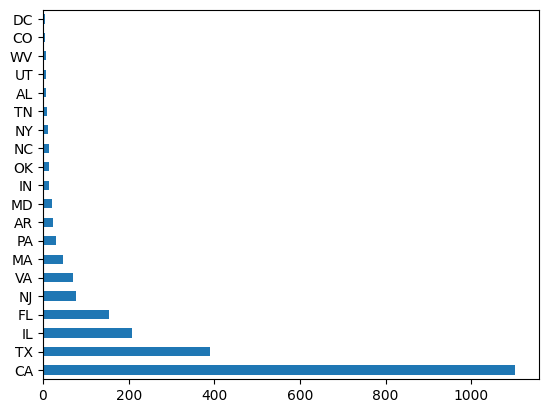

In [36]:
filtered_df['user_state'].value_counts().nlargest(20).plot(kind='barh')

[]

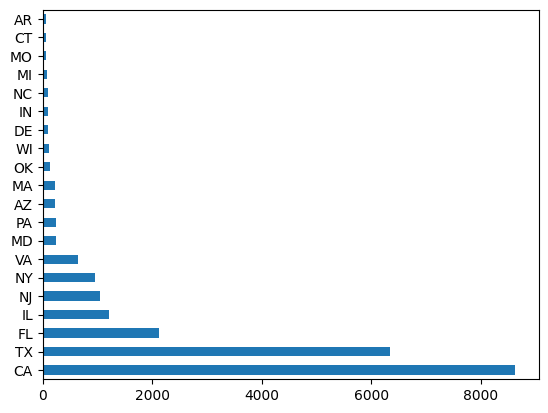

In [39]:
df['user_state'].value_counts().nlargest(20).plot(kind='barh').plot(kind='barh')

[]

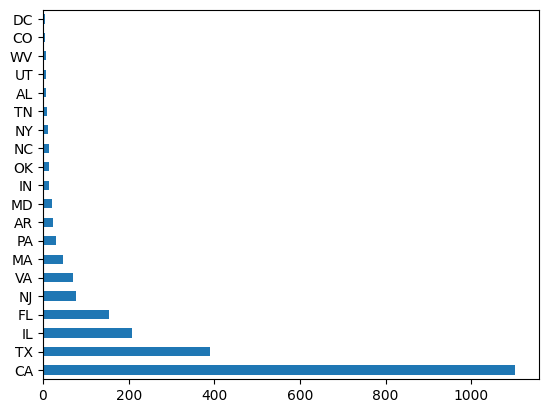

In [40]:
filtered_df['user_state'].value_counts().nlargest(20).plot(kind='barh').plot(kind='barh')

#### Short summary:

And user state is not likely to cause the calcelation

## Dig into events

In [43]:
filtered_df['event_name'].value_counts().nlargest(10).index.to_list()

['Chat Conversation Opened',
 'Chat Conversation Started',
 'Account History Transaction Details',
 'Wallet Opened',
 'Order',
 'Calculator View',
 'Sign Out',
 'Add Vehicle Break',
 'Add Vehicle Success',
 'Subscription Premium Renew']

In [85]:
transaction_df = pd.DataFrame.from_records(filtered_df[filtered_df['event_name'] == 'Account History Transaction Details']['event_attributes'].apply(lambda x: json.loads(x)).to_list())
transaction_df.groupby('Navigated From').value_counts()

Navigated From   Status   Type                 
Account History  Pending  Auto Payment             57
                 Paid     Pro Plan Subscription    42
                 Pending  Violation Transaction    31
                 Paid     Order                    19
                          Violation Transaction     8
                 Overdue  Order                     1
account_history  Paid     Pro Plan Subscription    91
                          Order                    22
                 Overdue  Order                     2
dtype: int64

In [108]:
transaction_all_df = pd.DataFrame.from_records(df[df['event_name'] == 'Account History Transaction Details']['event_attributes'].apply(lambda x: json.loads(x)).to_list())
transaction_all_df.groupby('Navigated From').value_counts()

Navigated From   Type                   Status 
Account History  Violation Transaction  Pending    200
                 Auto Payment           Pending    188
                 Pro Plan Subscription  Paid       184
                 Order                  Paid       128
                                        Overdue     23
                 Violation Transaction  Paid        21
                 Forced Payment         Pending     12
                 Manual Payment         Pending      7
                 Promotion              Pending      1
                 Refund Transaction     Pending      1
account_history  Pro Plan Subscription  Paid       263
                 Order                  Paid       173
                                        Overdue     21
                 Pro Plan Subscription  Overdue      4
                 Violation Transaction  Overdue      2
                                        Paid         2
dtype: int64

In [78]:
filtered_df.loc['a22abda7a39d747ab674cd13224b375a'].sort_values(by='event_created_date')['event_attributes'].to_list()

['{"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}',
 '{"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}',
 '{"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}',
 '{"Navigated From":"Account History","Status":"Paid","Type":"Pro Plan Subscription"}',
 '{}',
 '{"Navigated From":"Account History","Status":"Paid","Type":"Pro Plan Subscription"}',
 '{"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}',
 '{"Navigated From":"Account History","Status":"Pending","Type":"Violation Transaction"}',
 '{}',
 '{"Navigated From":"Account History","Status":"Paid","Type":"Pro Plan Subscription"}',
 '{"Navigated From":"Account History","Status":"Pending","Type":"Auto Payment"}',
 '{}']

In [116]:
filtered_df.loc['a22abda7a39d747ab674cd13224b375a']

,user_state,event_name,event_attributes,event_platform,device_manufacture,device_model
event_created_date,,,,,,
2022-01-15 23:28:37,FL,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Pending"",""Type"":""Violation Transaction""}",android,LGE,LM-V350
2022-01-16 02:39:15,FL,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Pending"",""Type"":""Violation Transaction""}",android,LGE,LM-V350
2022-01-16 02:39:28,FL,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Pending"",""Type"":""Violation Transaction""}",android,LGE,LM-V350
2022-01-16 02:39:48,FL,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Paid"",""Type"":""Pro Plan Subscription""}",android,LGE,LM-V350
2022-01-16 02:40:39,FL,Wallet Opened,{},android,LGE,LM-V350
2022-01-22 21:14:00,FL,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Paid"",""Type"":""Pro Plan Subscription""}",android,LGE,LM-V350
2022-01-22 21:14:25,FL,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Pending"",""Type"":""Violation Transaction""}",android,LGE,LM-V350
2022-01-22 21:14:36,FL,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Pending"",""Type"":""Violation Transaction""}",android,LGE,LM-V350
2022-01-22 21:15:56,FL,Wallet Opened,{},android,LGE,LM-V350


In [105]:
chat_df = pd.DataFrame.from_records(filtered_df[filtered_df['event_name'] == 'Chat Conversation Opened']['event_attributes'].apply(lambda x: json.loads(x)).to_list(), columns=['From', 'Transaction type'])
chat_df.value_counts()

From                 Transaction type     
Menu                                          86
Transaction Details  AutoPayment              20
                     Pro Plan Subscription    19
                     OrderAlert               11
                     ForcedPayment             3
                     OrderPayment              3
Dashboard                                      2
                                               1
Deeplink                                       1
dtype: int64

In [134]:
filtered_df.loc[filtered_df[filtered_df['event_attributes'].str.contains('Violation')].index.get_level_values(0).unique()].head(50)

user_state  \
userid                           event_created_date               
a22abda7a39d747ab674cd13224b375a 2022-01-15 23:28:37         FL   
                                 2022-01-16 02:39:15         FL   
                                 2022-01-16 02:39:28         FL   
                                 2022-01-16 02:39:48         FL   
                                 2022-01-16 02:40:39         FL   
                                 2022-01-22 21:14:00         FL   
                                 2022-01-22 21:14:25         FL   
                                 2022-01-22 21:14:36         FL   
                                 2022-01-22 21:15:56         FL   
                                 2022-01-25 16:58:58         FL   
                                 2022-01-25 16:59:12         FL   
                                 2022-01-25 16:59:33         FL   
18b9953f2328fed7482dda3deb45dcf5 2022-02-04 23:54:34         CA   
                                 2022-02-06 15:13:16         CA   
                                 2022-02-08 15:26:13         CA   
                                 2022-02-09 01:50:31         CA   
                                 2022-02-10 01:42:04         CA   
                                 2022-02-12 01:15:41         CA   
                                 2022-02-12 16:29:43         CA   
                                 2022-02-14 14:31:05         CA   
                                 2022-02-16 14:21:58         CA   
                                 2022-02-22 01:15:33         CA   
                                 2022-02-22 14:25:06         CA   
                                 2022-02-23 16:17:31         CA   
                                 2022-03-06 06:41:09         CA   
                                 2022-03-06 06:44:52         CA   
                                 2022-03-06 06:45:00         CA   
                                 2022-03-06 06:45:00         CA   
                                 2022-03-06 15:07:13         CA   
                                 2022-03-06 22:19:04         CA   
                                 2022-03-06 22:19:04         CA   
                                 2022-03-06 22:19:22         CA   
a6817108396d1fa6a480424ed8a07c41 2022-02-05 20:32:35         TX   
                                 2022-02-05 22:45:34         TX   
                                 2022-02-05 23:16:36         TX   
                                 2022-02-08 07:04:48         TX   
                                 2022-02-12 19:06:56         TX   
                                 2022-02-15 15:25:14         TX   
                                 2022-02-16 06:53:56         TX   
                                 2022-02-16 06:55:37         TX   
                                 2022-02-17 01:43:02         TX   
                                 2022-02-18 15:03:14         TX   
                                 2022-02-19 12:14:39         TX   
                                 2022-02-25 08:51:32         TX   
                                 2022-02-25 08:51:57         TX   
578a167f3ac0dde4f7d640f73a162fbb 2022-02-06 03:40:46         CA   
                                 2022-02-07 14:30:59         CA   
                                 2022-02-07 15:25:58         CA   
                                 2022-02-07 15:25:58         CA   
                                 2022-02-07 15:25:58         CA   

                                                                               event_name  \
userid                           event_created_date                                         
a22abda7a39d747ab674cd13224b375a 2022-01-15 23:28:37  Account History Transaction Details   
                                 2022-01-16 02:39:15  Account History Transaction Details   
                                 2022-01-16 02:39:28  Account History Transaction Details   
                                 2022-01-16 02:39:48  Account History Transaction Details   
          

In [128]:
filtered_df.loc['ca79374cbefb71b9bdfdc7151c0c5ccf']

,user_state,event_name,event_attributes,event_platform,device_manufacture,device_model
event_created_date,,,,,,
2022-03-01 22:58:02,TX,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Paid"",""Type"":""Pro Plan Subscription""}",android,samsung,SM-G998U1
2022-03-01 22:58:12,TX,Chat Conversation Opened,"{""From"":""Transaction Details"",""Transaction type"":""Pro Plan Subscription""}",android,samsung,SM-G998U1
2022-03-01 22:58:12,TX,Chat Conversation Started,{},android,samsung,SM-G998U1
2022-03-01 23:06:42,TX,Chat Conversation Opened,"{""From"":""Menu"",""Transaction type"":""""}",android,samsung,SM-G998U1
2022-03-01 23:06:42,TX,Chat Conversation Started,{},android,samsung,SM-G998U1
2022-03-01 23:50:03,TX,Chat Conversation Opened,"{""From"":""Menu"",""Transaction type"":""""}",android,samsung,SM-G998U1
2022-03-01 23:50:03,TX,Chat Conversation Started,{},android,samsung,SM-G998U1
2022-03-01 23:55:01,TX,Chat Conversation Opened,"{""From"":""Menu"",""Transaction type"":""""}",android,samsung,SM-G998U1
2022-03-01 23:55:01,TX,Chat Conversation Started,{},android,samsung,SM-G998U1


In [174]:
a = len(filtered_df[filtered_df['event_attributes'].str.contains('"Status":"Pending","Type":"Auto Payment"')].index.get_level_values(0).unique().to_list())
b = len(df[df['event_attributes'].str.contains('"Status":"Pending","Type":"Auto Payment"')].index.get_level_values(0).unique().to_list())
a / b

0.14893617021276595

In [181]:
filtered_df.loc['387c88f25e204376acf003420663fef5']

,user_state,event_name,event_attributes,event_platform,device_manufacture,device_model
event_created_date,,,,,,
2022-04-16 18:53:16,AR,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""Pending"",""Type"":""Auto Payment""}",android,samsung,SM-G970U
2022-04-16 18:56:00,AR,Wallet Opened,{},android,samsung,SM-G970U


### Event properties summary

It looks that the most common behavior of all users that made cancelation - transaction problems. 

1. First of all, it is the most common issue considering information from chat event attributes (after general "Menu" one)
2. More than half of the top 10 events before cancelation is more or less about transactions
4. Every 7th user with "AutoPayment" transaction type canceled subscription.

## To sum up

1. We found top 10 events to look at:

['Chat Conversation Opened',
 'Chat Conversation Started',
 'Account History Transaction Details',
 'Wallet Opened',
 'Order',
 'Calculator View',
 'Sign Out',
 'Add Vehicle Break',
 'Add Vehicle Success',
 'Subscription Premium Renew']
 
2. We checked user and device params and found that they are not likely to have a big influence on the target prediction, but can have influence on transaction processes

3. And the core problem to work on is the transactions. This is the most common issue for users and the technical support logs confirm it.

4. After checking event attributes for the transactions events, we found out, that there can be some pattern or technical issue with this functionality, as for example, every 7th user, who had Auto Payment transaction details, canceled subscription 